In [1]:
from pyFRF import FRF
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Showcase of the package ``pyFRF``

Apr 2019, J. Slavič (janko.slavic@fs.uni-lj.si, [ladisk.si/~slavic](http://ladisk.si/~slavic))

pyFRF is part of the [www.openmodal.com](http://www.openmodal.com) project.

The inputs are time signals of excitation and response, the outputs are FRF estimators (H1, H2, Hv, Vector or ODS) and coherence.

## Create synthetic FRF

In [2]:
C = 0.5+0.1j # modal constant
eta = 5e-3   # damping loss factor
f0 = 320     # natural frequency
df = 1      # freq resolution
D = 1e-8*(1-.1j)    # residual

f = 1*np.arange(0, 1400, step=df) # / frequency range
    
w0 = f0 * 2 * np.pi #to rad/s
w = f * 2 * np.pi
H1_syn = C / (w0 ** 2 - w ** 2 + 1.j * eta * w0 ** 2) + \
        +0.5*np.conj(C) / ((w0*2)** 2 - w ** 2 + 1.j * eta * (w0*2)** 2)\
        +0.25*C / ((w0*3)** 2 - w ** 2 + 1.j * eta * (w0*3)** 2)\
        + D

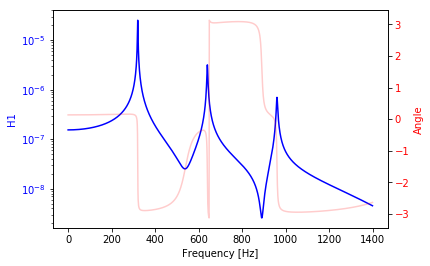

In [3]:
fig, ax1 = plt.subplots()
ax1.semilogy(f,np.abs(H1_syn), 'b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('H1', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(f,np.angle(H1_syn), 'r', alpha=0.2)
ax2.set_ylabel('Angle', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

## Prepare synthetic impulse response

In [4]:
h = np.fft.irfft(H1_syn)
l = len(H1_syn)*2-2
t = np.linspace(0, 1, num=l)
exc = np.zeros_like(t)
exc[0] = 1

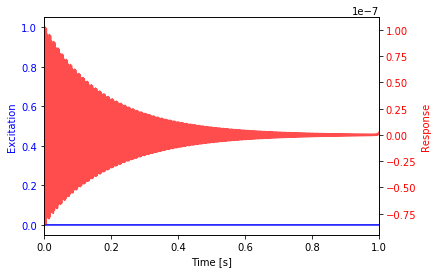

In [5]:
fig, ax1 = plt.subplots()
ax1.plot(t, exc, 'b');
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Excitation', color='b')
ax1.set_xlim(left=0, right=1)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(t, h, 'r', alpha=0.7)
ax2.set_ylabel('Response', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

## Go back to frequency domain via pyFRF

In [6]:
frf = FRF(sampling_freq=1/t[1], exc=exc, resp=h, exc_window='None', resp_type='d', resp_window='None')

In [7]:
len(frf.get_f_axis())

1400

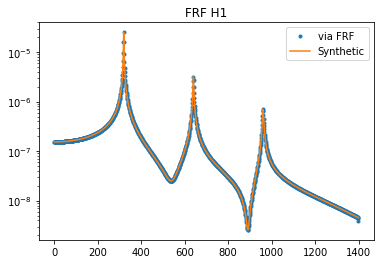

In [8]:
plt.semilogy(frf.get_f_axis(), np.abs(frf.get_FRF()), '.', label='via FRF')
plt.semilogy(f, np.abs(H1_syn), label='Synthetic')
plt.title('FRF H1')
plt.legend();

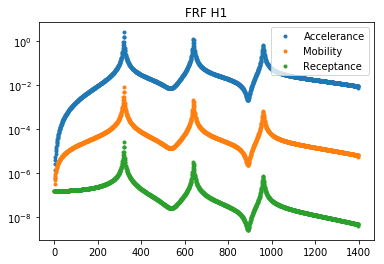

In [9]:
plt.semilogy(frf.get_f_axis(), np.abs(frf.get_FRF(form='accelerance')), '.', label='Accelerance')
plt.semilogy(frf.get_f_axis(), np.abs(frf.get_FRF(form='mobility')), '.', label='Mobility')
plt.semilogy(frf.get_f_axis(), np.abs(frf.get_FRF(form='receptance')), '.', label='Receptance')
plt.title('FRF H1')
plt.legend();

## Go back to frequency domain via pyFRF - multiple measurements with noise

In [10]:
# prepare the instance of FRF 
averages = 10
frf = FRF(sampling_freq=1/t[1], fft_len=len(h), exc_window='None', \
          resp_window='None', resp_type='d', weighting='Linear', n_averages=averages)

In [11]:
k = 0.1 # rate of noise
for i in range(averages):
    noise = k * (np.random.rand(len(h))-0.5) * np.std(h)
    frf.add_data(exc, h + noise)

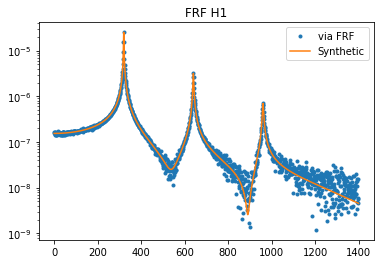

In [12]:
plt.semilogy(frf.get_f_axis(), np.abs(frf.get_H1()), '.', label='via FRF')
plt.semilogy(f, np.abs(H1_syn), label='Synthetic')
plt.title('FRF H1')
plt.legend();

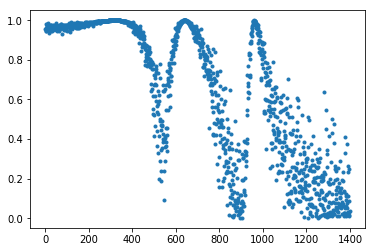

In [13]:
plt.plot(frf.get_f_axis(), frf.get_coherence(), '.');

## Averaging multiple separate measurements with double impact detection

If required, please install lvm_read.

In [14]:
#!pip install lvm_read

In [15]:
import lvm_read

Read the LabView measurement data:

In [16]:
measurement_filename = './data/impact2_response0.lvm'
measurement_file = lvm_read.read(measurement_filename)

Look at the LabView Measurement File:

In [17]:
measurement_file.keys()

dict_keys(['Decimal_Separator', 'Writer_Version', 'Reader_Version', 'Separator', 'Multi_Headings', 'X_Columns', 'Time_Pref', 'Operator', 'Date', 'Time', 0, 1, 2, 3, 4, 'Segments'])

There a several segments in this file (repetitions of measurements at particular excitation/response location)

In [18]:
measurement_file['Segments']

5

The first repetition is:

In [19]:
measurement_file[0].keys()

dict_keys(['Channels', 'Samples', 'Date', 'Time', 'Y_Unit_Label', 'X_Dimension', 'X0', 'Delta_X', 'data', 'Channel names'])

Lets check the data of segment 0:

In [20]:
segment = 1
measurement_file[segment]['Channel names']

['Force (Trigger)', 'Acceleration (Trigger)', 'Comment']

In [21]:
force = measurement_file[segment]['data'][:,0]
acceleration = measurement_file[segment]['data'][:,1]
dt = measurement_file[segment]['Delta_X'][0]
time = dt*np.arange(len(force))

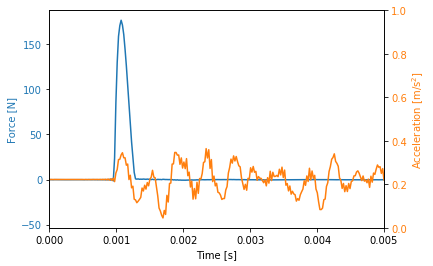

In [22]:
fig, ax1 = plt.subplots()
ax1.plot(time, force, label='Force', color='C0');
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Force [N]', color='C0')
ax1.set_xlim(left=0, right=0.002)
for tl in ax1.get_yticklabels():
    tl.set_color('C0')
    
ax2 = ax1.twinx()
ax1.plot(time, acceleration, label='Force', color='C1');
ax2.set_ylabel('Acceleration [m/s$^2$]', color='C1')
for tl in ax2.get_yticklabels():
    tl.set_color('C1')
ax1.set_xlim(0, 0.005);

Now we have to prepare the FRF object to be fed with impact measurements:

In [23]:
frf_meas = FRF(sampling_freq=int(1 / dt), 
               fft_len=len(force), 
               exc_window='Force:0.03', 
               resp_window='Exponential:0.01',
               weighting='Linear', 
               n_averages=measurement_file['Segments'])

In [24]:
i = 0
for segment in range(measurement_file['Segments']):
    force = measurement_file[segment]['data'][:,0]
    acceleration = measurement_file[segment]['data'][:,1]
    if frf_meas.is_data_ok(exc=force, resp=acceleration, overflow_samples=3, double_impact_limit=1e-3):
        frf_meas.add_data(exc=force, resp=acceleration)
        i+=1
    else:
        print(f'Overflow or double-impact identified at segment: {segment}. This segment was not added.')

Overflow or double-impact identified at segment: 0. This segment was not added.
Overflow or double-impact identified at segment: 2. This segment was not added.


We can now check the segment 0 (this data was hand overflowed):

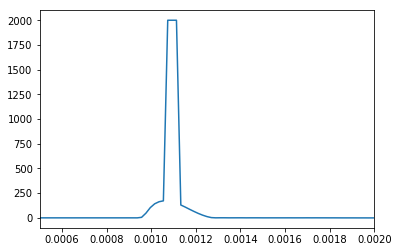

In [25]:
segment = 0
force = measurement_file[segment]['data'][:,0]
time = dt*np.arange(len(force))
plt.plot(time, force, label=f'Segment {segment}')
plt.xlim(5e-4,20e-4);

And the segment 2:

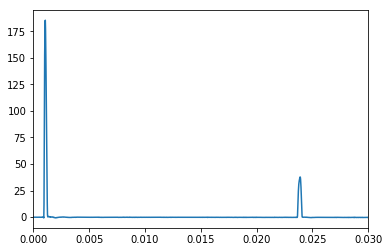

In [26]:
segment = 2
force = measurement_file[segment]['data'][:,0]
time = dt*np.arange(len(force))
plt.plot(time, force, label=f'Segment {segment}')
plt.xlim(0,30e-3);

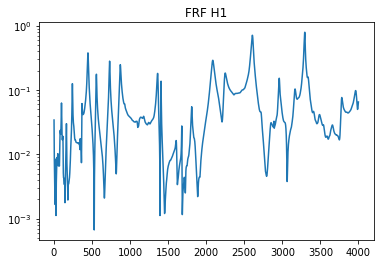

In [27]:
plot_up_to = 4000
plt.semilogy(frf_meas.get_f_axis()[:plot_up_to], np.abs(frf_meas.get_FRF(form='accelerance'))[:plot_up_to])
plt.title('FRF H1');

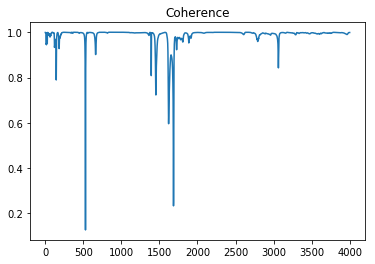

In [28]:
plt.plot(frf_meas.get_f_axis()[:plot_up_to], frf_meas.get_coherence()[:plot_up_to]);
plt.title('Coherence');